# Homework assignments (For who needs an exam grade)

### We are given a dataset containing 510 images which are categorized according two main characteristics/properties: “C1” and “C2”. The following inputs are available:
* #### `input image', a 110 × 110 × 3 real-valued tensor. The last dimension denotes the number of input channels; the images belong to different combinations of the two properties C1 and C2. For C1 and C2 we have 5 and 6 possible values, respectively;  among the 30 possible couples (C1,C2), we have images for only 24 of them. We have around 20 samples (little more or less) for each of the available couples;  values in each tensor entry are integers in [0, 255];
* #### C1, string, the value for the C1 property. 5 possible values;
* #### C2, string, the value for the C2 property. 6 possible values.

### Design a deep neural network model to predict the class of an image, given by the couple (C1,C2).

### Provide a sketch of each of the following points, then implement your solution.
1. MODEL: Which architecture do you consider the most appropriate for this task, and why;
2. INPUT:
* After a potential preprocessing step, which is the input of the model, and
how is it represented;
3. OUTPUT: How would you design the output layer and why;
4. LOSS: Which loss function would you use to train your model and why;
5. MODEL CONFIGURATION:
 Model composition (composition of layers, regardless their number,
or their dimension, which can be object of tuning)
6. MODEL EVALUATION: How would you assess (in which setting) the
generalization capabilities of the model on unseen data?


My solution:

1. I will use a convolutional network. It is a imige clasification task, so a convolutional network that can extract important information using positional information seems fit for the task. I will use simple convolutional infrastructure, that gradualy deecreses the volume of data by 0.5 every step. Then, in the last step I will have 2 clasification heads that will separatly try to clasyfy the C1 class and the C2 class. This way, when the model faces unknown data, it may still be able to corectly clasify at least some labels (eg if it has seen color red during training, but not pands, it will be able to corectly say that the red pants it sees are red).
2. The imput is a picture, that is a tensor of dimensions [B, C, W, H]. The first two dimensions corespond to batch and channels. It contains float numbers and has been rescailed to be between 0 and 1.
3. The output layers are 2 linear layers. Linear layer is a standard way to clasyfi data, using eariel results from a convolutional network. I explain why I use 2 of them above.
4. I use a multi class cross entropy loss. It is a standard loss function for claasification tasks. I calculate the loss for 2 heads separetly and them sum it up.
5. The model consists of convolutional layers, with relu activatio function and dropout and batch norm added for regularyzation. Then, there are 2 linear layers for final clasification.
6. I belive the model will not be albe to generalize corectly (apart from type of situations described in point 1)

In [21]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize, Compose

In [22]:
import pickle as pk
# Open the pickle data
with open('input.pkl', 'rb') as f:
  data = pk.load(f)

images = data['imgs']
C1 = data['C1']
C2 = data['C2']
print(f"length image:{len(images)}")
print(f"length C1:{len(C1)}")
print(f"length C2:{len(C2)}")

length image:510
length C1:510
length C2:510


Lets take a quick look at the data

In [23]:
print(type(images[0]))

<class 'numpy.ndarray'>


In [24]:
print(images[0].shape)

(110, 110, 3)


In [25]:
a = set(C1)
b = set(C2)
print(a, b)

{'shirt', 'pants', 'shorts', 'dress', 'shoes'} {'blue', 'black', 'red', 'white', 'brown', 'green'}


Lets define some helper function to pre proces the data

In [26]:
def get_class_labels_from_c1(list):
    result = list.copy()
    for i in range(len(list)):
        obj = list[i]
        if obj == 'dress':
            c = 0
        if obj == 'shoes':
            c = 1
        if obj == 'shirt':
            c = 2
        if obj == 'shorts':
            c = 3
        if obj == 'pants':
            c = 4
        result[i] = c
    return result
def get_class_labels_from_c2(list):
    result = list.copy()
    for i in range(len(list)):
        obj = list[i]
        if obj == 'black':
            c = 0
        if obj == 'red':
            c = 1
        if obj == 'white':
            c = 2
        if obj == 'blue':
            c = 3
        if obj == 'green':
            c = 4
        if obj == 'brown':
            c = 5
        result[i] = c
    return result
labels_c1 = get_class_labels_from_c1(C1)
labels_c2 = get_class_labels_from_c2(C2)

In [27]:
def show_img(i, images):
    plt.imshow(images[i])
    print(f'C1: {C1[i]}, C2: {C2[i]}')
    plt.show()

In [28]:
def swap(imgs):
    swapped_imgs = imgs.copy()
    for n in range(len(swapped_imgs)):
        test_swapped = swapped_imgs[n].copy()
        test_swapped[:,:,0], test_swapped[:,:,2] = swapped_imgs[n][:,:,2], swapped_imgs[n][:,:,0]
        swapped_imgs[n] = test_swapped
    return swapped_imgs


In [29]:
proper_imgs = swap(images)

Lets look at an example of our data

C1: dress, C2: black


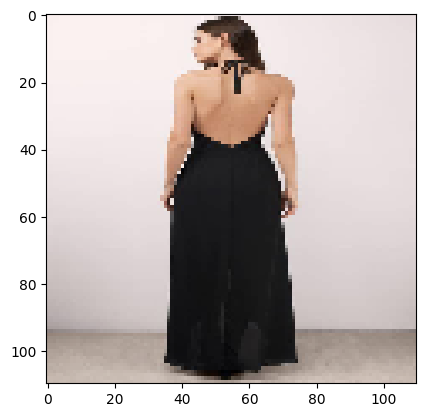

In [30]:
for i in range(1):
    show_img(i, proper_imgs)

Creating custom dataset

In [31]:
import torch
from torch.utils.data import Dataset
import numpy as np

my_preprocess = Compose([ToTensor(),
                        Normalize((0,), (1,))])

class NumpyArrayDataset(Dataset):
    def __init__(self, data, labels_c1, labels_c2, transform=None):
        self.data = data
        self.labels_c1 = labels_c1
        self.labels_c2 = labels_c2
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        label_c1 = self.labels_c1[index]
        label_c2 = self.labels_c2[index]
        if self.transform:
            image = self.transform(image)
        return image, label_c1, label_c2

dataset = NumpyArrayDataset(proper_imgs, labels_c1, labels_c2,  my_preprocess)

In [32]:
# possibly extract a validation dataset
from torch.utils.data import random_split
val_size = 60

# for reproducibility
torch.manual_seed(1)

train_size = len(dataset) - val_size
train_data, val_data = random_split(dataset, [train_size, val_size])
len(train_data), len(val_data)

(450, 60)

Creating Dataloader

In [33]:
# we'll use a batch size of 128 for training our network
batch_size = 128

# initialize a DataLoader object for each dataset
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data,
                                               batch_size=batch_size)



# grab the first batch from one of our DataLoader objects
example_batch_img, example_batch_label_c1, example_batch_label_c2 = next(iter(train_dataloader))

# inputs and labels are batched together as tensor objects
print(f"Batch inputs shape: {example_batch_img.shape}, Batch labels shape: C1 {example_batch_label_c1.shape}, C2 {example_batch_label_c2.shape}")

Batch inputs shape: torch.Size([128, 3, 110, 110]), Batch labels shape: C1 torch.Size([128]), C2 torch.Size([128])


Creating a model

In [45]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=32,
                               kernel_size = 3,
                               padding='same')
        self.conv12 = nn.Conv2d(in_channels=32,
                               out_channels=32,
                               kernel_size = 3,
                               padding='same')
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size = 3,
                               padding='same')
        self.conv22 = nn.Conv2d(in_channels=64,
                               out_channels=64,
                               kernel_size = 3,
                               padding='same')
        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size = 3,
                               padding='same')
        self.conv32 = nn.Conv2d(in_channels=128,
                               out_channels=128,
                               kernel_size = 3,
                               padding='same')
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.25)
        self.dropout12 = nn.Dropout(0.25)
        self.dropout22 = nn.Dropout(0.25)
        self.dropout32 = nn.Dropout(0.25)
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc_c1_hidden = nn.Linear(21632, 100)
        self.fc_c2_hidden = nn.Linear(21632, 100)
        self.fc_c1 = nn.Linear(100, 5)
        self.fc_c2 = nn.Linear(100, 6)
        #self.batch_norm1 = nn.BatchNorm2d(32)
        #self.batch_norm2 = nn.BatchNorm2d(64)
        #self.batch_norm3 = nn.BatchNorm2d(128)
    def forward(self, x):
        #print('zaczyna sie forward. x.shape = ', x.shape)

        x = self.conv1(x)
        #x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv12(x)
        x = self.dropout1(x)
        x = F.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout12(x)
        #x = self.relu(x)
        x = self.conv2(x)
        #x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(x)
        x = self.conv22(x)
        x = F.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout22(x)
        x = self.conv3(x)
        #x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.relu(x)
        x = self.conv32(x)
        x = F.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout32(x)
        #print(x.shape)
        x = torch.flatten(x, 1)
        #print(x.shape)
        c1_class = self.fc_c1_hidden(x)
        c2_class = self.fc_c2_hidden(x)
        c1_class = F.relu(c1_class)
        c2_class = F.relu(c2_class)
        c1_class = self.fc_c1(c1_class)
        c2_class = self.fc_c2(c2_class)
        output_c1 = F.log_softmax(c1_class, dim=1)
        output_c2 = F.log_softmax(c2_class, dim=1)
        return output_c1, output_c2

Training

In [36]:
# Computing the accuracy of a test set
def evaluate(model, test_loader, error):
#model = mlpinplace=False
    #print('evaluate start')
    model.eval()
    with torch.no_grad():
        correct_c1 = 0
        correct_c2 = 0
        correct_c1_and_c2 = 0
        cur_loss = 0
        #print('wchodze do petli')
        for test_imgs, test_labels_c1, test_labels_c2 in test_loader:
            output_c1, output_c2 = model(test_imgs)
            #test_labels = torch.squeeze(test_labels)
            #test_labels = test_labels.long()
            loss_c1 = error(output_c1, test_labels_c1)
            loss_c2 = error(output_c2, test_labels_c2)
            loss = loss_c1 + loss_c2
            #loss = error(output, test_labels)
            cur_loss+=loss.item()
            predicted_c1 = torch.max(output_c1,1)[1]
            predicted_c2 = torch.max(output_c2,1)[1]
            correct_c1 += (predicted_c1 == test_labels_c1).sum()
            correct_c2 += (predicted_c2 == test_labels_c2).sum()
            correct_c1_and_c2 += (((predicted_c2 == test_labels_c2) * (predicted_c1 == test_labels_c1))).sum()
    model.train()
    return cur_loss/len(test_loader.dataset), correct_c1/len(test_loader.dataset), correct_c2/len(test_loader.dataset), correct_c1_and_c2/len(test_loader.dataset)



#training the model
def fit(model, train_loader, error, test_loader, epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)#,lr=0.001, betas=(0.9,0.999))


    model.train()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        cur_loss = 0
        correct = 0
        for X_batch, y_batch_c1, y_batch_c2 in train_loader:
            optimizer.zero_grad()
            output_c1, output_c2 = model(X_batch)
            loss_c1 = error(output_c1, y_batch_c1)
            loss_c2 = error(output_c2, y_batch_c2)
            loss = loss_c1 + loss_c2
            cur_loss+= loss.item()
            loss.backward()
            optimizer.step()

        train_losses.append(cur_loss/len(train_loader.dataset))

        test_loss, accuracy_c1, accuracy_c2, accuracy_c1_and_c2 = evaluate(model, test_loader, error)
        test_losses.append(test_loss)
        print(f'Epoch : {epoch},  train loss:{train_losses[-1]}, test loss:{test_losses[-1]}, accuracy C1 = {accuracy_c1}, accuracy C2 = {accuracy_c2}, Joint accuracy = {accuracy_c1_and_c2}')

    return train_losses, test_losses

In [46]:
epochs = 50
model = CNN()
error = nn.CrossEntropyLoss() # Loss for multiclass classification
train_losses, test_losses = fit(model,train_dataloader, error, val_dataloader, epochs)

Epoch : 0,  train loss:0.030343657069736057, test loss:0.05690069993336996, accuracy C1 = 0.11666666716337204, accuracy C2 = 0.20000000298023224, Joint accuracy = 0.01666666753590107
Epoch : 1,  train loss:0.029976860152350533, test loss:0.05683832168579102, accuracy C1 = 0.2666666805744171, accuracy C2 = 0.18333333730697632, Joint accuracy = 0.01666666753590107
Epoch : 2,  train loss:0.02985778119828966, test loss:0.056795573234558104, accuracy C1 = 0.2666666805744171, accuracy C2 = 0.13333334028720856, Joint accuracy = 0.03333333507180214
Epoch : 3,  train loss:0.029805263413323298, test loss:0.05675716002782186, accuracy C1 = 0.2666666805744171, accuracy C2 = 0.15000000596046448, Joint accuracy = 0.03333333507180214
Epoch : 4,  train loss:0.029655545552571615, test loss:0.056681195894877114, accuracy C1 = 0.2666666805744171, accuracy C2 = 0.25, Joint accuracy = 0.06666667014360428
Epoch : 5,  train loss:0.02938749207390679, test loss:0.05670412381490072, accuracy C1 = 0.116666667163

KeyboardInterrupt: 

Chack if new version was uploaded

<Figure size 640x480 with 0 Axes>

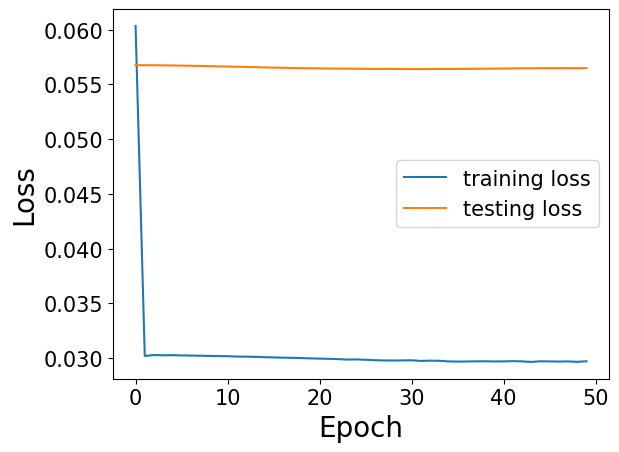

<Figure size 640x480 with 0 Axes>

In [48]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label="training loss")
plt.plot(test_losses,label="testing loss")
plt.legend(fontsize=15)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure()